# SQL Database agent

Here we'll show how to perform evaluations with agents using a SQL DB agent as an example:

See our conceptual guide and agent tutorial for more context:
 
* https://docs.smith.langchain.com/concepts/evaluation
* https://docs.smith.langchain.com/tutorials/Developers/agents

In [ ]:
%pip install --upgrade --quiet  langchain langchain-community langchain-experimental langgraph

In [1]:
import os 
os.environ["LANGCHAIN_PROJECT"] = "sql-agent"
os.environ["LANGCHAIN_API_KEY"] = "xxx"

## Database setup 
 
Follow [these instructions](https://database.guide/2-sample-databases-sqlite/) to set up `Chinook.db`.

In [26]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

## SQL Agent

We'll use a [LangGraph agent](https://www.langchain.com/agents) with access to a SQL toolkit:

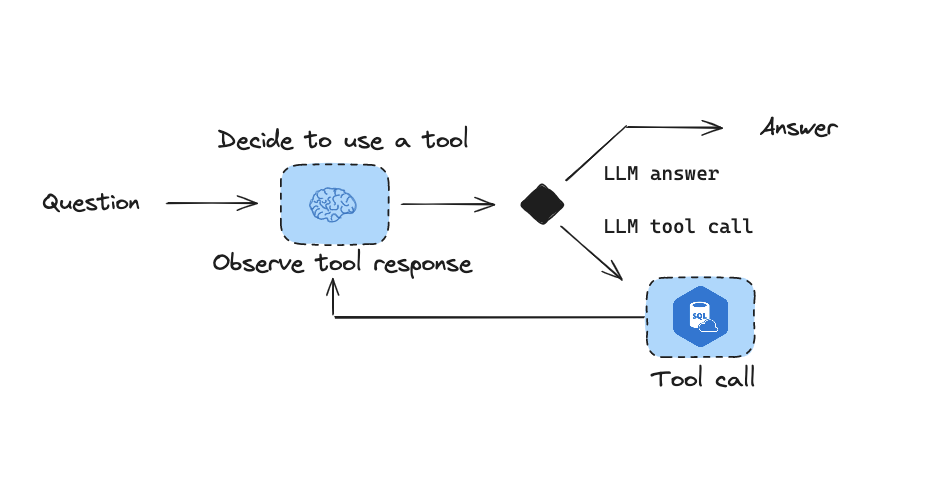

### Tools

Use [SQL toolkit](https://python.langchain.com/v0.2/docs/tutorials/sql_qa/#agents) and some custom tools.

In [84]:
import json

from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import SQLDatabaseToolkit

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt.tool_node import ToolNode
from langchain_core.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import tool

# SQL toolkit
toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model="gpt-4o"))
tools = toolkit.get_tools()

# Query checking
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

Execute the correct query with the appropriate tool."""
query_check_prompt = ChatPromptTemplate.from_messages([("system", query_check_system),("user", "{query}")])
query_check = query_check_prompt | ChatOpenAI(model="gpt-4o", temperature=0)

@tool
def check_query_tool(query: str) -> str:
    """
    Use this tool to double check if your query is correct before executing it.
    """
    return query_check.invoke({"query": query}).content

# Query result checking
query_result_check_system = """You are grading the result of a SQL query from a DB. 
- Check that the result is not empty.
- If it is empty, instruct the system to re-try!"""
query_result_check_prompt = ChatPromptTemplate.from_messages([("system", query_result_check_system),("user", "{query_result}")])
query_result_check = query_result_check_prompt | ChatOpenAI(model="gpt-4o", temperature=0)

@tool
def check_result(query_result: str) -> str:
    """
    Use this tool to check the query result from the database to confirm it is not empty and is relevant.
    """
    return query_result_check.invoke({"query_result": query_result}).content

tools.append(check_query_tool)
tools.append(check_result)

### State

In [74]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### SQL Assistant

Use [prompt from here](https://python.langchain.com/v0.2/docs/tutorials/sql_qa/#agents).

In [75]:
from langchain_core.runnables import Runnable, RunnableConfig

# Assistant
class Assistant:
    
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            # Append to state
            state = {**state}
            # Invoke the tool-calling LLM
            result = self.runnable.invoke(state)
            # If it is a tool call -> response is valid
            # If it has meaninful text -> response is valid
            # Otherwise, we re-prompt it b/c response is not meaninful
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

# Assistant runnable
query_gen_system = """
ROLE:
You are an agent designed to interact with a SQL database. You have access to tools for interacting with the database.
GOAL:
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
INSTRUCTIONS:
- Only use the below tools for the following operations.
- Only use the information returned by the below tools to construct your final answer.
- To start you should ALWAYS look at the tables in the database to see what you can query. Do NOT skip this step.
- Then you should query the schema of the most relevant tables.
- Write your query based upon the schema of the tables. You MUST double check your query before executing it. 
- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
- You can order the results by a relevant column to return the most interesting examples in the database.
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- If you get an error while executing a query, rewrite the query and try again.
- If the query returns a result, first check the query result.
- If the query result result is empty, think about the table schema, rewrite the query, and try again.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""

query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system),("placeholder", "{messages}")])
assistant_runnable = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools)

### Graph Utilities

In [76]:
def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

### Graph

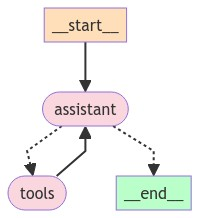

In [77]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.runnables import RunnableLambda

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition, 
    # "tools" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"tools": "tools", END: END},
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### Test

In [8]:
questions = ["Which country's customers spent the most? And how much did they spend?",
             "How many albums does the artist Led Zeppelin have?",
             "What was the most purchased track of 2017?",
             "Which sales agent made the most in sales in 2009?"]

In [ ]:
## Invoke

import uuid 
_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

msg = {"messages": ("user", questions[0])}
messages = graph.invoke(msg,config)
messages['messages'][-1].content

In [ ]:
## Stream

import uuid 
_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[0])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

### Eval
 
[Agent evaluation](https://docs.smith.langchain.com/concepts/evaluation#agents) can focus on 3 things:

* `Response`: The inputs are a prompt and a list of tools. The output is the agent response.
* `Single tool`: As before, the inputs are a prompt and a list of tools. The output the tool call.
* `Trajectory`: As before, the inputs are a prompt and a list of tools. The output is the list of tool calls

#### Response

`Dataset`

First, create a dataset that evaluates end-to-end performance of the agent.

We can take some questions from [here](https://github.com/brianchiang-tw/SQL_for_DataScience/blob/master/Module3_Practice_Quiz).

In [17]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    ("Which country's customers spent the most? And how much did they spend?", "The country whose customers spent the most is the USA, with a total expenditure of $523.06"),
    ("What was the most purchased track of 2013?", "The most purchased track of 2013 was Hot Girl."),
    ("How many albums does the artist Led Zeppelin have?","Led Zeppelin has 14 albums"),
    ("What is the total price for the album “Big Ones”?","The total price for the album 'Big Ones' is 14.85"),
    ("Which sales agent made the most in sales in 2009?", "Steve Johnson made the most sales in 2009"),
]

dataset_name = "SQL Agent Response"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

`Run chain`

In [18]:
def predict_sql_agent_answer(example: dict):
    """Use this for answer evaluation"""
    msg = {"messages": ("user", example["input"])}
    messages = graph.invoke(msg, config)
    return {"response": messages['messages'][-1].content}

`Evaluator`

This can [follow what we do for RAG](https://docs.smith.langchain.com/tutorials/Developers/rag).

In [19]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = prompt = hub.pull("langchain-ai/rag-answer-vs-reference")

def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get question, ground truth answer, RAG chain answer
    input_question = example.inputs["input"]    
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke({"question": input_question,
                                  "correct_answer": reference,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_v_reference_score", "score": score}

`Create evaluation`

In [ ]:
from langsmith.evaluation import evaluate

dataset_name = "SQL Agent Response"
experiment_results = evaluate(
    predict_sql_agent_answer,
    data=dataset_name,
    evaluators=[answer_evaluator],
    experiment_prefix="sql-agent-response-v-reference",
    metadata={"version": "Chinook, gpt-4o base-case agent"},
)

#### Single tool

We can check a specific tool call using [custom evaluators](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#use-custom-evaluators).

In [66]:
def predict_assistant(example: dict):
    """Invoke assistant for single tool call evaluation"""
    msg = [ ("user", example["input"]) ]
    result = assistant_runnable.invoke({"messages":msg})
    return {"response": result}

In [78]:
from langsmith.schemas import Example, Run

def check_specific_tool_call(root_run: Run, example: Example) -> dict:
    """
    Check if the first tool call in the response matches the expected tool call.
    """

    # Exepected tool call
    expected_tool_call = 'sql_db_list_tables'

    # Run
    response = root_run.outputs["response"]

    # Get tool call
    try:
        tool_call = getattr(response, 'tool_calls', [])[0]['name']

    except (IndexError, KeyError):
        tool_call = None

    score = 1 if tool_call == expected_tool_call else 0
    return {"score": score, "key": "single_tool_call"}

In [ ]:
experiment_results = evaluate(
    predict_assistant,
    data=dataset_name,
    evaluators=[check_specific_tool_call],
    experiment_prefix="sql-agent-single-tool-calling",
    metadata={"version": "Chinook, gpt-4o base-case agent"},
)

#### Trajectory

We can check a trajectory of tool calls using [custom evaluators](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#use-custom-evaluators).

In [81]:
def predict_sql_agent_messages(example: dict):
    """Use this for answer evaluation"""
    msg = {"messages": ("user", example["input"])}
    messages = graph.invoke(msg, config)
    return {"response": messages}

In [87]:
def find_tool_calls(messages):
    """  
    Find all tool calls in the messages returned 
    """
    tool_calls = [tc['name'] for m in messages['messages'] for tc in getattr(m, 'tool_calls', [])]
    return tool_calls

def contains_all_tool_calls_any_order(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in any order.
    """
    expected = ['sql_db_list_tables', 'sql_db_schema', 'sql_db_query_checker', 'sql_db_query', 'check_result']
    messages = root_run.outputs["response"]
    tool_calls = find_tool_calls(messages)
    if set(expected) <= set(tool_calls):
        score = 1
    else: 
        score = 0
    return {"score": int(score), "key": "multi_tool_call_any_order"}

def contains_all_tool_calls_in_order(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order.
    """
    messages = root_run.outputs["response"]
    tool_calls = find_tool_calls(messages)
    print("Tool calls:")
    print(tool_calls)
    it = iter(tool_calls)
    expected = ['sql_db_list_tables', 'sql_db_schema', 'sql_db_query_checker', 'sql_db_query', 'check_result']
    if all(elem in it for elem in expected):
        score = 1
    else: 
        score = 0
    return {"score": int(score), "key": "multi_tool_call_in_order"}

In [ ]:
experiment_results = evaluate(
    predict_sql_agent_messages,
    data=dataset_name,
    evaluators=[contains_all_tool_calls_any_order,contains_all_tool_calls_in_order],
    experiment_prefix="sql-agent-response-tool-calling",
    metadata={"version": "Chinook, gpt-4o base-case agent"},
)